In [1]:
import os, sys
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import time
import shutil
import collections
from pathlib import Path

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Loading packages

In [3]:
import sys
from pathlib import Path

here_path = Path().resolve()
repo_path = here_path.parents[1]
sys.path.append(str(repo_path))

In [4]:
from py.utils import verifyDir, verifyFile, verifyType

In [5]:
import graphviz
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from py.config import Config

cfg = Config()

np.random.seed(cfg.RANDOM_STATE)
cfg.DATA_PATH, cfg.MODEL_PATH

('/media/felipe/DATA19/datasets/', '/media/felipe/DATA19/models/')

In [7]:
QSCORE_PATH=f"{cfg.DATA_PATH}pp2/Qscores/"
IMAGES_PATH = f"{cfg.DATA_PATH}pp2/images/"
MODEL_PATH = f"{cfg.MODEL_PATH}pp2/cnn/"
EXPLAIN_PATH = f"{cfg.MODEL_PATH}pp2/explanations/"

In [8]:
verifyDir(MODEL_PATH)
verifyDir(EXPLAIN_PATH)

### Verify GPU

In [9]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch_type = torch.float32 if device.type == "cuda" else torch.float16
device, torch_type

(device(type='cuda'), torch.float32)

### Loading data

In [10]:
NUM_CLASSES = 1 if "reg" in cfg.ML_TASK else 2

In [11]:
%%time
data_df = pd.read_csv(f"{QSCORE_PATH}scores.csv", sep=";", low_memory=False)
data_df["image_path"] = f"{IMAGES_PATH}" + data_df["image_path"]
data_df["image_id"] = data_df["image_id"].apply(str)
data_df.sort_values(by=[cfg.PERCEPTION_METRIC], ascending=False, inplace=True)
data_df

CPU times: user 151 ms, sys: 30.1 ms, total: 181 ms
Wall time: 181 ms


,image_id,lat,long,city,country,continent,safety,beautiful,wealthy,lively,boring,depressing,image_path
98091,51414746fdc9f04926006a00,44.961377,-93.271491,Minneapolis,USA,North America,8.780423,7.500000,7.777778,6.278770,5.000000,3.333333,/media/felipe/DATA19/datasets/pp2/images/Minne...
42815,513d677cfdc9f035870040af,42.370774,-71.126977,Boston,USA,North America,8.583389,5.333333,6.055556,5.029020,3.333333,9.166667,/media/felipe/DATA19/datasets/pp2/images/Bosto...
50565,513d7c38fdc9f03587006e0f,33.805683,-84.293833,Atlanta,USA,North America,8.505291,6.342593,8.452381,2.291667,0.000000,3.333333,/media/felipe/DATA19/datasets/pp2/images/Atlan...
16840,50f5642cfdc9f065f00060f0,47.583294,-122.287884,Seattle,USA,North America,8.478006,7.166667,7.500000,5.538597,3.333333,2.777778,/media/felipe/DATA19/datasets/pp2/images/Seatt...
32864,513cc19efdc9f035870014bd,29.751635,-95.466232,Houston,USA,North America,8.440027,7.592593,6.653439,4.321429,2.708333,1.666667,/media/felipe/DATA19/datasets/pp2/images/Houst...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1768,50f42c0bfdc9f065f0001786,52.242431,20.898414,Warsaw,Poland,Europe,0.392157,5.899471,2.833333,4.872958,5.740741,3.333333,/media/felipe/DATA19/datasets/pp2/images/Warsa...
67419,513e6bb5fdc9f0358700c081,35.646141,139.812366,Tokyo,Japan,Asia,0.277778,3.333333,3.333333,4.538332,5.277778,7.438272,/media/felipe/DATA19/datasets/pp2/images/Tokyo...
15585,50f562dafdc9f065f0005ae6,1.292158,103.808340,Singapore,Singapore,Asia,0.256410,4.305556,3.333333,6.666667,5.333333,4.444444,/media/felipe/DATA19/datasets/pp2/images/Singa...
68591,513e6f20fdc9f0358700c51f,35.743776,139.773877,Tokyo,Japan,Asia,0.196078,5.092593,3.080808,6.603175,3.055556,2.500000,/media/felipe/DATA19/datasets/pp2/images/Tokyo...


### Loading Model

In [12]:
from py.models.classification.cnn.vgg import VGG16

model = VGG16(num_classes=2, use_gap=False)
model.load_state_dict(torch.load(f"{MODEL_PATH}{cfg.MODEL_FEATURE_NAME}_best_model.pth"))
model.eval()

VGG16(
  (feature_maps): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dila

#### Image test

In [13]:
from py.models.datasets.transformations import ImageTransforms

transforms_list = ImageTransforms().get(model_name=cfg.MODEL_FEATURE_NAME)
transforms_list

{'train': Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ),
 'val': Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 )}

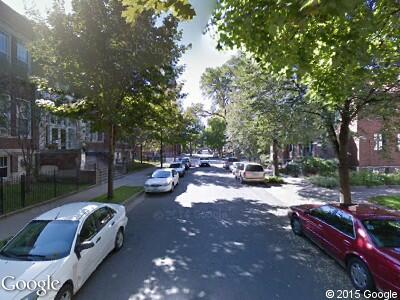

In [14]:
from PIL import Image

original_image = Image.open(data_df["image_path"].tolist()[0]).convert("RGB")
original_image

In [15]:
target_class = 1 # not safety

### GradCAM (Gradient-weighted Class Activation Mapping)

- **What it does**: Shows which parts of the image the model is "looking at" when making predictions
- **How it works**: Uses gradients flowing into the last convolutional layer to highlight important regions
- **Speed**: Very fast (~0.1 seconds per image)
- **Best for**: Understanding spatial attention and localization

In [16]:
from py.models.explainers import GradCAM

gradcam = GradCAM(model)

In [17]:
# Generate explanation (input_tensor: 1x3x224x224, original_image: HxWx3)
cam_heatmap, gradcam_predicted_class = gradcam.generate_cam(
                                            original_image,
                                            transforms_list=transforms_list["val"],
                                            target_class=target_class  # None = use predicted class, or specify a class index
                                        )

#### GradCAM Interpretation

- **Red/Yellow regions**: Areas the model focuses on most
- **Blue regions**: Areas the model ignores
- **Heatmap**: Shows spatial importance across the image
- **Good for**: "Where is the model looking?"

In [18]:
# Generate explanation (input_tensor: 1x3x224x224, original_image: HxWx3)
gradcam_viz, cam_resized = gradcam.visualize(
                    original_image,
                    cam_heatmap,
                )

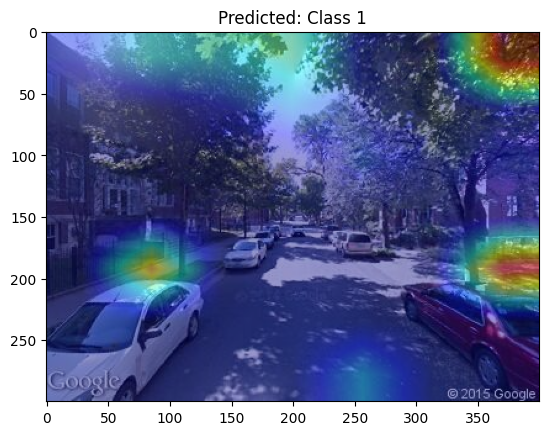

In [19]:
plt.imshow(gradcam_viz)
plt.title(f'Predicted: Class {gradcam_predicted_class}')
plt.show()

### LIME (Local Interpretable Model-agnostic Explanations)

- **What it does**: Highlights which image regions contribute most to the prediction
- **How it works**: Perturbs the image and sees how predictions change
- **Speed**: Slower (~30-60 seconds per image with 1000 samples)
- **Best for**: Understanding feature importance in a human-interpretable way

In [20]:
from py.models.explainers import ImageLIME

# Create LIME explainer
lime_explainer = ImageLIME(model)

In [21]:
%%time
explanation, lime_predicted_class = lime_explainer.explain(
                                        original_image,
                                        transforms_list["val"],
                                        target_class=target_class,
                                        num_samples=1000,  # More samples = better but slower
                                    )

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 15min 55s, sys: 22.9 s, total: 16min 17s
Wall time: 1min 3s


#### LIME Interpretation

- **Green regions**: Features that increase the class probability
- **Red regions**: Features that decrease the class probability
- **Superpixels**: Image is divided into interpretable segments
- **Good for**: "Which features matter for this prediction?"

In [22]:
lime_viz = lime_explainer.visualize(original_image, 
                                   explanation,
                                   target_class=lime_predicted_class,
                                   num_features=10,      # Show top 10 superpixels
                                   positive_only=False   # Show both positive and negative contributions
                                )

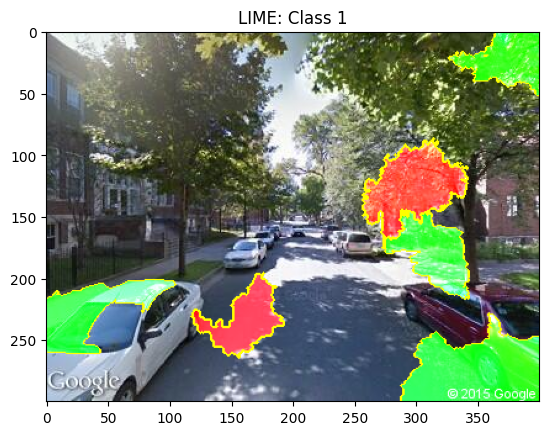

In [23]:
plt.imshow(lime_viz)
plt.title(f'LIME: Class {lime_predicted_class}')
plt.show()

#### Visualize both

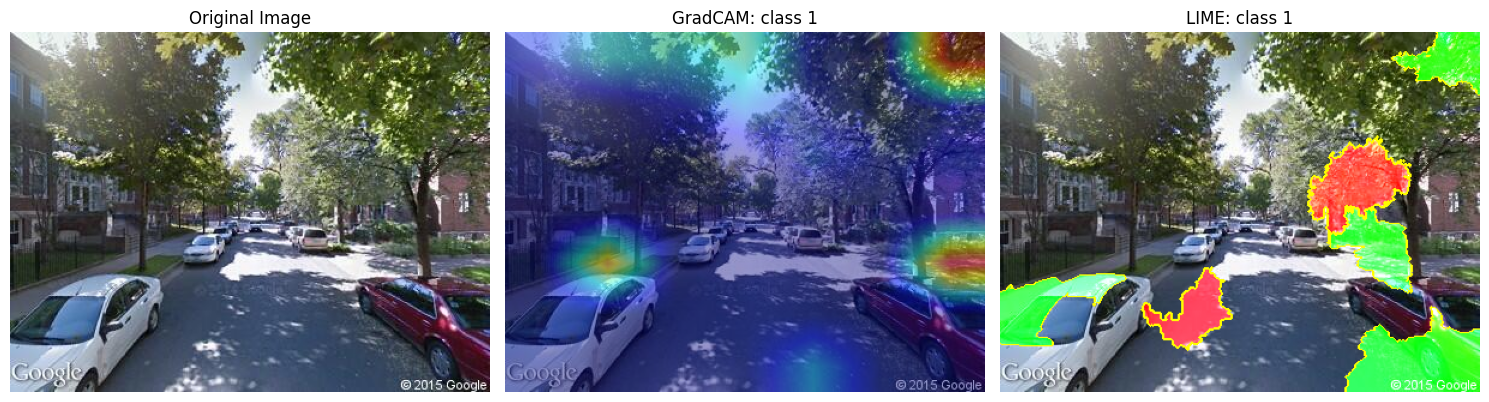

In [24]:
# Create figure
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[0].axis('off')

# GradCAM
axes[1].imshow(gradcam_viz)
axes[1].set_title(f'GradCAM: class {gradcam_predicted_class}')
axes[1].axis('off')

# LIME
axes[2].imshow(lime_viz)
axes[2].set_title(f'LIME: class {lime_predicted_class}')
axes[2].axis('off')

plt.tight_layout()
plt.show()